<a href="https://colab.research.google.com/github/aadmberrada/WalmartSales/blob/main/DTS_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 - Import

In [34]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option('display.max_rows', 100)
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import time
import xgboost
from xgboost import XGBRegressor 
import catboost
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import re



In [4]:
PATH = "/content/drive/MyDrive/DTS/walmart-recruiting-store-sales-forecasting"

train = pd.read_csv(PATH+ "/train.csv")
features = pd.read_csv(PATH+ "/features.csv")
stores = pd.read_csv(PATH+ "/stores.csv")
ss = pd.read_csv(PATH+ "/sampleSubmission.csv")

# 1 - Présentation des jeux de données

In [5]:
train = train.drop("IsHoliday", axis = 1)
train.head()

,Store,Dept,Date,Weekly_Sales
0,1,1,2010-02-05,24924.50
1,1,1,2010-02-12,46039.49
2,1,1,2010-02-19,41595.55
3,1,1,2010-02-26,19403.54
4,1,1,2010-03-05,21827.90


In [6]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [7]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [8]:
df = pd.merge(left = train, right = features ,on = ['Date', "Store"], how = 'inner')
df.head()

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,1,2010-02-05,24924.50,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2,2010-02-05,50605.27,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
2,1,3,2010-02-05,13740.12,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
3,1,4,2010-02-05,39954.04,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
4,1,5,2010-02-05,32229.38,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False


In [9]:
#df.to_csv(PATH + '/bdd_merged.csv')

# 3 - Exploration du jeu de données (Analyse descriptive, statistiques descriptives, visualisation)

Voir Dashboards

# 4 - Features Engineering

Création de plusieurs variables

In [10]:
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d")
df['year'] = df["Date"].dt.year
df['month'] = df["Date"].dt.month
df['day'] = df["Date"].dt.day
df['week'] = df["Date"].dt.week

In [11]:
# Création lags (days)
# Lag 
for lag in list(range(4, 25, 4)):
    df['Weekly_Sales_'+str(lag)] = df.groupby(
        ['Store',	'Dept'], 
        as_index = False)['Weekly_Sales'].shift(lag).astype(np.float64)
#df = df.drop("Weekly_Sales_0", axis = 1)
df.head()

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,year,month,day,week,Weekly_Sales_4,Weekly_Sales_8,Weekly_Sales_12,Weekly_Sales_16,Weekly_Sales_20,Weekly_Sales_24
0,1,1,2010-02-05,24924.50,42.31,2.572,NaN,NaN,NaN,NaN,...,2010,2,5,5,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,2010-02-05,50605.27,42.31,2.572,NaN,NaN,NaN,NaN,...,2010,2,5,5,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3,2010-02-05,13740.12,42.31,2.572,NaN,NaN,NaN,NaN,...,2010,2,5,5,NaN,NaN,NaN,NaN,NaN,NaN
3,1,4,2010-02-05,39954.04,42.31,2.572,NaN,NaN,NaN,NaN,...,2010,2,5,5,NaN,NaN,NaN,NaN,NaN,NaN
4,1,5,2010-02-05,32229.38,42.31,2.572,NaN,NaN,NaN,NaN,...,2010,2,5,5,NaN,NaN,NaN,NaN,NaN,NaN


Création de variables

In [12]:
df['Store_sales_avg'] = df.groupby('Store')['Weekly_Sales'].transform('mean').astype(np.float64)
df['Dept_sales_avg'] = df.groupby('Dept')['Weekly_Sales'].transform('mean').astype(np.float64)
df['Store_Dept_sales_avg'] = df.groupby(['Store','Dept'])['Weekly_Sales'].transform('mean').astype(np.float64)

df = df.replace(np.inf, np.nan)

Creéation de variables

In [13]:
df['Super_Bowl']   =  np.where(((df['Date'] == "2010-02-10") | (df['Date'] == "2011-02-11") | 
                                (df['Date'] == "2012-02-10") | (df['Date'] == "2013-02-08")), 1, 0)

df['Labor_day']    =  np.where(((df['Date'] == "2010-09-10") | (df['Date'] == "2011-09-09") | 
                                (df['Date'] == "2012-09-07") | (df['Date'] == "2013-09-06")), 1, 0)

df['Thanksgiving'] =  np.where(((df['Date'] == "2010-11-26") | (df['Date'] == "2011-11-25") | 
                                (df['Date'] == "2012-11-23") | (df['Date'] == "2013-11-29")), 1, 0)

df['Christmas']    =  np.where(((df['Date'] == "2010-12-31") | (df['Date'] == "2011-12-30") | 
                                (df['Date'] == "2012-12-28") | (df['Date'] ==  "2013-12-27")),1, 0)

In [14]:
df["Benefice"] = np.where(df["Weekly_Sales"]>0, 1, 0)

df["Benefice"].value_counts()

1    420212
0      1358
Name: Benefice, dtype: int64

1358 sans avoir de bénéfice

# 5 -Data Cleaning

In [15]:
(df.isna().sum()/df.shape[0]).sort_values(ascending = False)

MarkDown2               0.736110
MarkDown4               0.679847
MarkDown3               0.674808
MarkDown1               0.642572
MarkDown5               0.640790
Weekly_Sales_24         0.179795
Weekly_Sales_20         0.150623
Weekly_Sales_16         0.121237
Weekly_Sales_12         0.091598
Weekly_Sales_8          0.061594
Weekly_Sales_4          0.031155
Store_Dept_sales_avg    0.000000
Dept_sales_avg          0.000000
Store_sales_avg         0.000000
Super_Bowl              0.000000
Labor_day               0.000000
Thanksgiving            0.000000
Christmas               0.000000
Store                   0.000000
day                     0.000000
week                    0.000000
Dept                    0.000000
month                   0.000000
year                    0.000000
IsHoliday               0.000000
Unemployment            0.000000
CPI                     0.000000
Fuel_Price              0.000000
Temperature             0.000000
Weekly_Sales            0.000000
Date      

On va supprimer les colonnes avec plus de 60% de NaN

In [16]:
df.columns[df.isna().sum()/df.shape[0]>0.6]

Index(['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], dtype='object')

In [17]:
to_del = list(df.columns[df.isna().sum()/df.shape[0]>0.6])
df = df.drop(to_del, axis = 1)
df.head()

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,year,...,Weekly_Sales_20,Weekly_Sales_24,Store_sales_avg,Dept_sales_avg,Store_Dept_sales_avg,Super_Bowl,Labor_day,Thanksgiving,Christmas,Benefice
0,1,1,2010-02-05,24924.50,42.31,2.572,211.096358,8.106,False,2010,...,NaN,NaN,21710.543621,19213.485088,22513.322937,0,0,0,0,1
1,1,2,2010-02-05,50605.27,42.31,2.572,211.096358,8.106,False,2010,...,NaN,NaN,21710.543621,43607.020113,46102.090420,0,0,0,0,1
2,1,3,2010-02-05,13740.12,42.31,2.572,211.096358,8.106,False,2010,...,NaN,NaN,21710.543621,11793.698516,13150.478042,0,0,0,0,1
3,1,4,2010-02-05,39954.04,42.31,2.572,211.096358,8.106,False,2010,...,NaN,NaN,21710.543621,25974.630238,36964.154476,0,0,0,0,1
4,1,5,2010-02-05,32229.38,42.31,2.572,211.096358,8.106,False,2010,...,NaN,NaN,21710.543621,21365.583515,24257.941119,0,0,0,0,1


In [18]:
(df.isna().sum()).sort_values(ascending = False)

Weekly_Sales_24         75796
Weekly_Sales_20         63498
Weekly_Sales_16         51110
Weekly_Sales_12         38615
Weekly_Sales_8          25966
Weekly_Sales_4          13134
Christmas                   0
Thanksgiving                0
Labor_day                   0
Super_Bowl                  0
Store_Dept_sales_avg        0
Dept_sales_avg              0
Store_sales_avg             0
Store                       0
Dept                        0
week                        0
day                         0
month                       0
year                        0
IsHoliday                   0
Unemployment                0
CPI                         0
Fuel_Price                  0
Temperature                 0
Weekly_Sales                0
Date                        0
Benefice                    0
dtype: int64

Pour les NaN, on utilise la méthode du Backward fill : on remplace les valeurs
manquantes dans le passé en se basant sur la première valeur connue après les manquantes. On l'utilise car les variables avec les NaN sont des Variables laguées.

In [19]:
for col in df.columns :
  if col.startswith("Weekly_Sales_"):
    df[col]  = df[col].bfill(axis ='rows')

In [20]:
df.isna().sum()

Store                   0
Dept                    0
Date                    0
Weekly_Sales            0
Temperature             0
Fuel_Price              0
CPI                     0
Unemployment            0
IsHoliday               0
year                    0
month                   0
day                     0
week                    0
Weekly_Sales_4          0
Weekly_Sales_8          0
Weekly_Sales_12         0
Weekly_Sales_16         0
Weekly_Sales_20         0
Weekly_Sales_24         0
Store_sales_avg         0
Dept_sales_avg          0
Store_Dept_sales_avg    0
Super_Bowl              0
Labor_day               0
Thanksgiving            0
Christmas               0
Benefice                0
dtype: int64

In [21]:
df = df.set_index(df["Date"])
df = df.drop(["Date","IsHoliday"], axis = 1)

In [22]:
df.shape

(421570, 25)

# 6 - Préparation des données

# 7 - Sélection de différents modèles (explications des critères de sélection, choix de la métrique, …)

### 7 - 0 - Fn

In [21]:
#stores = df.Store.unique()

In [22]:
#df = df.loc[:'2010-06-30']
#On prend 6 mois
df.shape

(421570, 25)

In [23]:
df.columns

Index(['Store', 'Dept', 'Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment', 'year', 'month', 'day', 'week', 'Weekly_Sales_4',
       'Weekly_Sales_8', 'Weekly_Sales_12', 'Weekly_Sales_16',
       'Weekly_Sales_20', 'Weekly_Sales_24', 'Store_sales_avg',
       'Dept_sales_avg', 'Store_Dept_sales_avg', 'Super_Bowl', 'Labor_day',
       'Thanksgiving', 'Christmas', 'Benefice'],
      dtype='object')

In [24]:
df[df['year']==2011].index

DatetimeIndex(['2011-01-07', '2011-01-07', '2011-01-07', '2011-01-07',
               '2011-01-07', '2011-01-07', '2011-01-07', '2011-01-07',
               '2011-01-07', '2011-01-07',
               ...
               '2011-12-30', '2011-12-30', '2011-12-30', '2011-12-30',
               '2011-12-30', '2011-12-30', '2011-12-30', '2011-12-30',
               '2011-12-30', '2011-12-30'],
              dtype='datetime64[ns]', name='Date', length=153453, freq=None)

Pour la taille du train set, on va récupérer les données jusqu'en fin 2011. Donc on prend en compte 2 années pour chaque Store.

Le test set sera l'année 2012

In [25]:
df[df['year']==2012].index

DatetimeIndex(['2012-01-06', '2012-01-06', '2012-01-06', '2012-01-06',
               '2012-01-06', '2012-01-06', '2012-01-06', '2012-01-06',
               '2012-01-06', '2012-01-06',
               ...
               '2012-10-26', '2012-10-26', '2012-10-26', '2012-10-26',
               '2012-10-26', '2012-10-26', '2012-10-26', '2012-10-26',
               '2012-10-26', '2012-10-26'],
              dtype='datetime64[ns]', name='Date', length=127438, freq=None)

In [61]:
def model(model):
  importance_df = pd.DataFrame()
  stores = df.Store.unique()

  d_test = pd.DataFrame()
  d_train = pd.DataFrame()
  metrics = {}

  t1 = time.time()
  for store in stores:
    df_ = df[df['Store']==store]
    
    train = df_.loc[:'2011-12-30']
    #train = df_.loc[:'2010-05-31']

    scaler = MinMaxScaler()
    X_train = train.drop("Weekly_Sales", axis = 1)
    X_train_ = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train_, columns = X_train.columns)

    y_train = train["Weekly_Sales"]

    # Validation Prediction
    test = df_.loc['2012-01-06':]
    #test = df_.loc['2010-06-01':]

    #test_ = test.copy()
    #X_test__ = test_.drop("Weekly_Sales", axis = 1)

    X_test = test.drop("Weekly_Sales", axis = 1)
    X_test_ = scaler.transform(X_test)
    X_test = pd.DataFrame(X_test_, columns = X_test.columns)
    y_test = test["Weekly_Sales"]

    X_test = X_test.set_index(y_test.index)
    y_test = test["Weekly_Sales"]

      # Train and validate
    model = model
    
    """ 
    model =  LGBMRegressor(
            n_estimators=100,
            learning_rate=0.03,
            subsample=0.8,
            colsample_bytree=0.8,
            max_depth=8,
            num_leaves=50,
            min_child_weight=300
        )
    """
    
    # Fit model
    model.fit(X_train, y_train)

    test_pred = model.predict(X_test)
    pred = pd.DataFrame(test_pred)
    pred = pred.set_index(y_test.index)
    predictions_test = pd.concat([y_test, pred], axis = 1)
    predictions_test.columns = ["Weekly_Sales", "y_pred_test"]
    predictions_test["Store"] = store
    #predictions_test["erreur_test"] = predictions_test["Weekly_Sales"] - predictions_test["y_pred_test"]

    test_pred_train = model.predict(X_train)
    pred_train = pd.DataFrame(test_pred_train)
    pred_train = pred_train.set_index(y_train.index)
    predictions_train = pd.concat([y_train, pred_train], axis = 1)
    predictions_train.columns = ["Weekly_Sales", "y_pred_train"]
    predictions_train["Store"] = store
    #predictions_train["erreur_train"] = predictions_train["Weekly_Sales"] - predictions_train["y_pred_train"]

    d_test = pd.concat([d_test, predictions_test], axis = 0)
    d_train = pd.concat([d_train, predictions_train], axis = 0)

  
    importance_df["features"] = [ col for col in X_train.columns if col != "Weekly_Sales"]
    importance_df["importance_"+str(store)] = model.feature_importances_
  
  importance_df["importance"] = np.mean(importance_df[[col for col in importance_df.columns if col!= "features"]], axis = 1)
  importance_df = importance_df[["features", "importance"]]
  t2 = time.time() - t1

  assert d_test.shape[0]  == df[df['year']==2012].shape[0]
  assert d_train.shape[0] == df[df['year']==2010].shape[0] + df[df['year']==2011].shape[0]

  print("Succès !")
  print("L'opération a duré "+str(round(t2, 2))+" sec")
  return model, d_test, d_train, importance_df, t2



In [62]:
def metrics_(predictions_test, predictions_train):

  metrics_dict = {"Store" : [], "RMSE_train" : [], "RMSE_test" : [], "MAE_train" : [], 
                                "MAE_test" : [],"RMSE_PCT_train": [], "RMSE_PCT_test": []}

  for store in predictions_train["Store"].unique():

    m_test = predictions_test[predictions_test["Store"]==store]
    rmse = np.sqrt(mean_squared_error(m_test["Weekly_Sales"], m_test["y_pred_test"]))
    mae = mean_absolute_error(m_test["Weekly_Sales"], m_test["y_pred_test"])
    rmse_pct = 100 * np.sqrt(np.mean((m_test["Weekly_Sales"] - m_test["y_pred_test"]) ** 2))/np.mean(m_test["y_pred_test"])

    m_train = predictions_train[predictions_train["Store"]==store]
    rmse_train = np.sqrt(mean_squared_error(m_train["Weekly_Sales"], m_train["y_pred_train"]))
    mae_train = mean_absolute_error(m_train["Weekly_Sales"], m_train["y_pred_train"])
    rmse_pct_train = 100 * np.sqrt(np.mean((m_train["Weekly_Sales"] - m_train["y_pred_train"]) ** 2))/np.mean(m_train["y_pred_train"])

    metrics_dict["Store"].append(store)

    metrics_dict["RMSE_train"].append(rmse_train)
    metrics_dict["RMSE_test"].append(rmse)

    metrics_dict["MAE_train"].append(mae_train) 
    metrics_dict["MAE_test"].append(mae)

    metrics_dict["RMSE_PCT_train"].append(rmse_pct_train)
    metrics_dict["RMSE_PCT_test"].append(rmse_pct)

  metrics = pd.DataFrame(metrics_dict)
  print(" -------> RMSE")
  print(" <--> Train : "+str(round(np.sqrt(mean_squared_error(predictions_train["Weekly_Sales"], predictions_train['y_pred_train'])),2)))
  print(" <--> Test  : "+str(round(np.sqrt(mean_squared_error(predictions_test["Weekly_Sales"], predictions_test['y_pred_test'])),2)))
  print("\n")
  print(" -------> MAE")
  print(" <--> Train : "+str(round(mean_absolute_error(predictions_train["Weekly_Sales"], predictions_train['y_pred_train']),2)))
  print(" <--> Test  : "+str(round(mean_absolute_error(predictions_test["Weekly_Sales"], predictions_test['y_pred_test']),2)))
  return metrics


In [63]:
def plot_metrics(metrics, model): 


  fig, axes = plt.subplots(2, 1, figsize=(16, 9), sharey=True)
  fig.suptitle(str(re.findall(r"\w+", str(model))[0]) + " - RMSE des différentes Stores")
  sns.barplot(ax=axes[0], x=metrics["Store"], y=metrics["RMSE_test"].values)
  axes[0].set_title("Test")
  sns.barplot(ax=axes[1], x=metrics["Store"], y=metrics["RMSE_train"].values)
  axes[1].set_title("Train")
  plt.show()

  fig, axes = plt.subplots(2, 1, figsize=(16, 9), sharey=True)
  fig.suptitle(str(re.findall(r"\w+", str(model))[0]) + " - MAE des différentes Stores")
  sns.barplot(ax=axes[0], x=metrics["Store"], y=metrics["MAE_test"].values)
  axes[0].set_title("Test")
  sns.barplot(ax=axes[1], x=metrics["Store"], y=metrics["MAE_train"].values)
  axes[1].set_title("Train")
  plt.show()


In [64]:
def imp_plot(importance_df, model):

  print(" ---- Features Importance")
  plt.figure(figsize=(30, 5))
  sns.barplot(x = "features", y = "importance", data = importance_df.sort_values(by="importance", ascending=False))
  plt.xticks(rotation=75)
  plt.title(str(re.findall(r"\w+", str(model))[0]) + " - Importance moyenne des différentes variables")
  plt.show()
  

### 7 - 1 - Machine Learning

#### Benchmark

In [87]:
def benchmark():

  importance_df = pd.DataFrame()
  stores = df.Store.unique()
  d_test = pd.DataFrame()
  d_train = pd.DataFrame()

  t1 = time.time()
  for store in stores:

    df_ = df[df['Store']==store]

    #train = df_.loc[:'2010-05-31']
    train = df_.loc[:'2011-12-30']

    scaler = MinMaxScaler()
    X_train = train.drop("Weekly_Sales", axis = 1)
    X_train_ = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train_, columns = X_train.columns)
    y_train = train["Weekly_Sales"]

    # Validation Prediction
    test = df_.loc['2012-01-06':]
    #test = df_.loc['2010-06-01':]

    #test_ = test.copy()
    #X_test__ = test_.drop("Weekly_Sales", axis = 1)

    X_test = test.drop("Weekly_Sales", axis = 1)
    X_test_ = scaler.transform(X_test)
    X_test = pd.DataFrame(X_test_, columns = X_test.columns)
    y_test = test["Weekly_Sales"]
    X_test = X_test.set_index(y_test.index)
    y_test = test["Weekly_Sales"]
      # Train and validate

    model =  LinearRegression()
 
    # Fit model
    model.fit(X_train, y_train)

    test_pred = model.predict(X_test)
    pred = pd.DataFrame(test_pred)
    pred = pred.set_index(y_test.index)
    predictions_test = pd.concat([y_test, pred], axis = 1)
    predictions_test.columns = ["Weekly_Sales", "y_pred_test"]
    predictions_test["Store"] = store
    predictions_test["erreur_test"] = predictions_test["Weekly_Sales"] - predictions_test["y_pred_test"]

    test_pred_train = model.predict(X_train)
    pred_train = pd.DataFrame(test_pred_train)
    pred_train = pred_train.set_index(y_train.index)
    predictions_train = pd.concat([y_train, pred_train], axis = 1)
    predictions_train.columns = ["Weekly_Sales", "y_pred_train"]
    predictions_train["Store"] = store
    predictions_train["erreur_train"] = predictions_train["Weekly_Sales"] - predictions_train["y_pred_train"]

    d_test = pd.concat([d_test, predictions_test], axis = 0)
    d_train = pd.concat([d_train, predictions_train], axis = 0)

    importance_df["features"] = [ col for col in X_train.columns if col != "Weekly_Sales"]
    importance_df['Coefficients'+str(store)] = model.coef_
    #importance_df = importance_df.set_index(X_train.columns)

  importance_df["importance"] = np.mean(importance_df[[col for col in importance_df.columns if col !="features"]], axis = 1)
  importance_df = importance_df[["features", "importance"]]

  t2 = time.time() - t1

  assert d_test.shape[0]  == df[df['year']==2012].shape[0]
  assert d_train.shape[0] == df[df['year']==2010].shape[0] + df[df['year']==2011].shape[0]

  print("Succès !")
  print("L'opération a duré "+str(round(t2, 2))+" sec")
  return model, d_test, d_train, importance_df, t2

model_lr, d_test_lr, d_train_lr, importance_df_lr, t2_lr = benchmark()

Succès !
L'opération a duré 3.24 sec


In [88]:
metrics_lr = metrics_(d_test_lr, d_train_lr)

 -------> RMSE
 <--> Train : 7187.8
 <--> Test  : 5251.66


 -------> MAE
 <--> Train : 2839.18
 <--> Test  : 3033.24


In [89]:
round(metrics_lr,2)

,Store,RMSE_train,RMSE_test,MAE_train,MAE_test,RMSE_PCT_train,RMSE_PCT_test
0,1,6325.73,4913.68,3230.29,3136.24,29.41,21.39
1,2,8952.66,6820.80,4346.77,4783.88,33.05,29.62
2,3,3096.33,3370.26,1320.17,1442.65,49.42,54.13
3,4,10248.41,6908.26,4653.73,3978.39,35.57,23.45
4,5,2233.31,1707.15,899.68,883.30,44.96,32.29
5,6,8063.80,5815.77,3715.67,3887.58,36.55,30.45
6,7,4517.77,3732.78,1903.67,2612.02,54.75,36.19
7,8,4629.08,3436.16,2270.10,2013.68,35.32,25.85
8,9,3591.04,2776.94,1671.73,1524.24,41.21,30.61
9,10,13970.54,8890.02,5184.34,6036.51,52.36,41.08


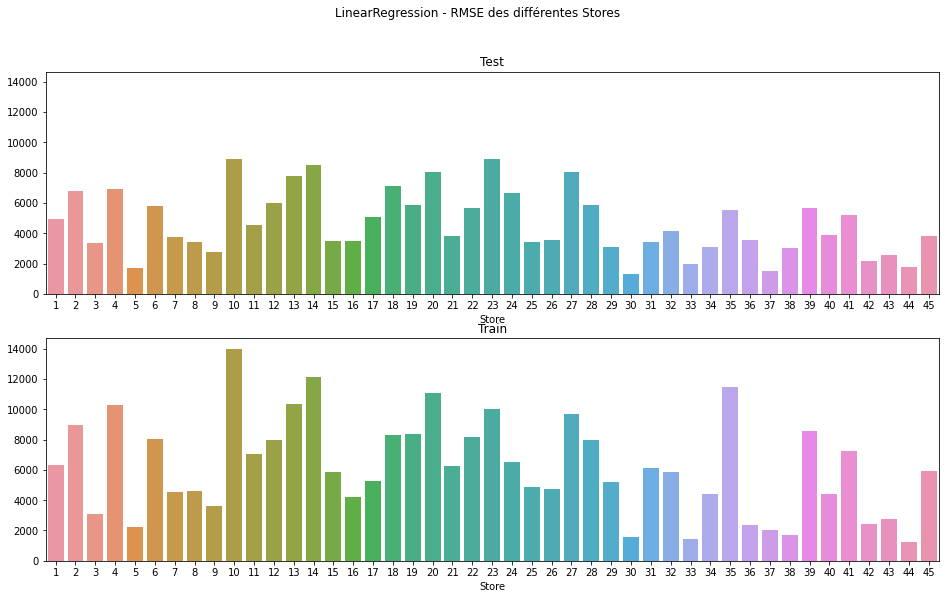

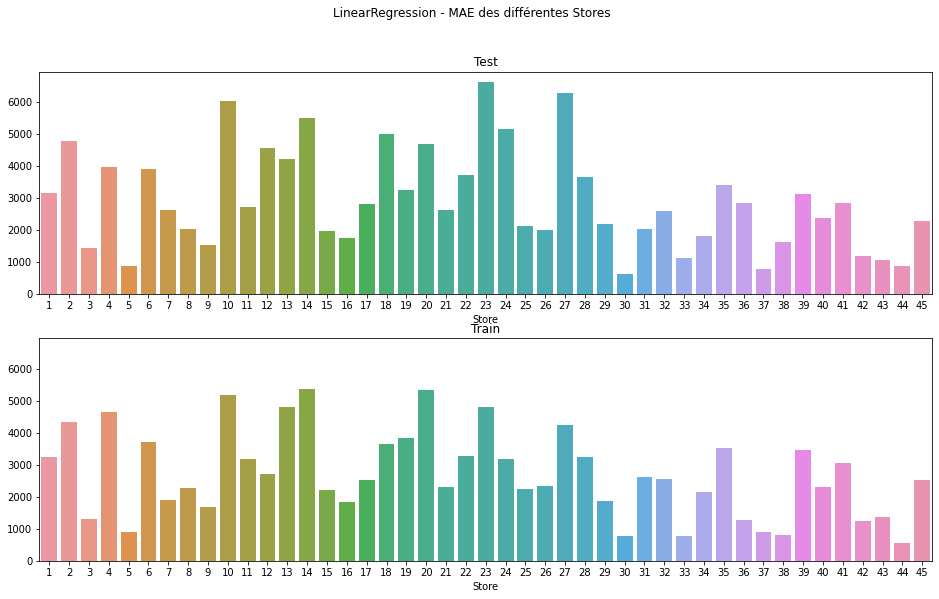

In [90]:
plot_metrics(metrics_lr, model_lr)

 ---- Features Importance


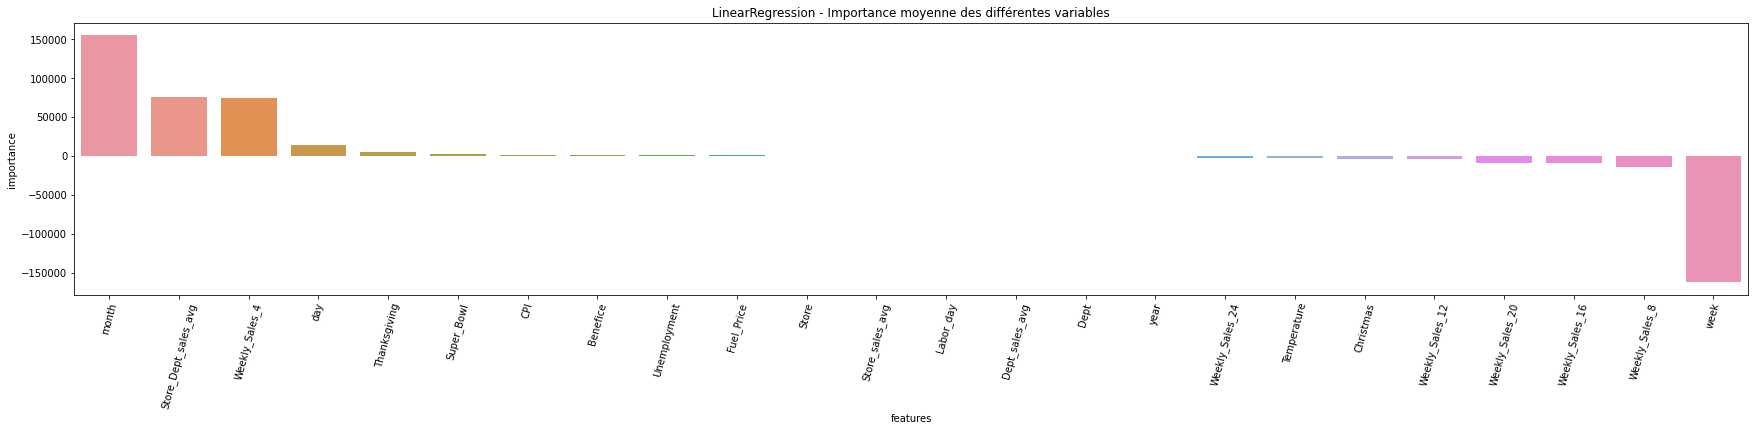

In [91]:
imp_plot(importance_df_lr, model_lr)

#### 1 - 1 - LGBMRegressor

In [128]:
model_lgbm, d_test_lgbm, d_train_lgbm, importance_df_lgbm, t2_lgbm = model(
  model = LGBMRegressor()
)


Succès !
L'opération a duré 18.89 sec


 -------> RMSE
 <--> Train : 3459.74
 <--> Test  : 3778.99


 -------> MAE
 <--> Train : 1413.97
 <--> Test  : 1862.99


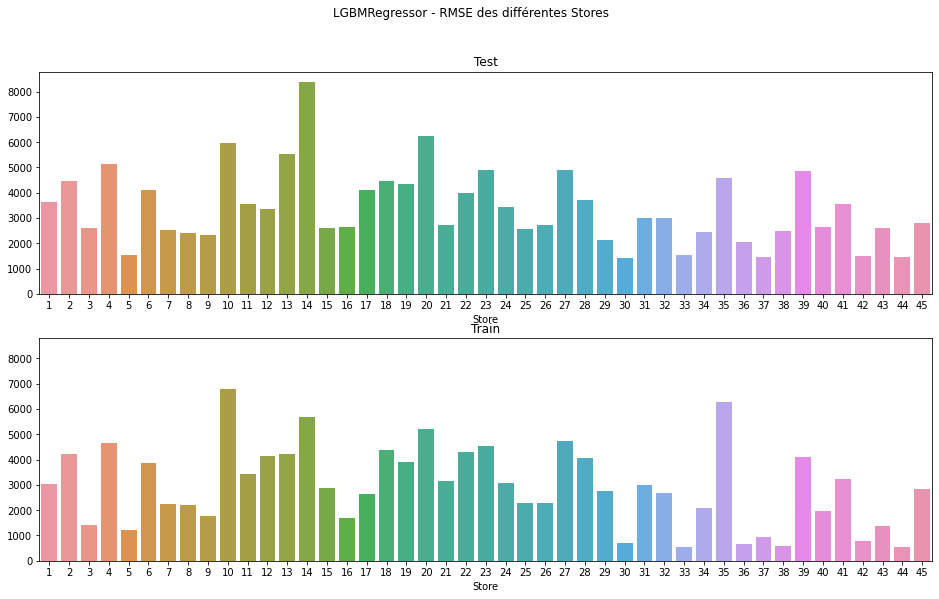

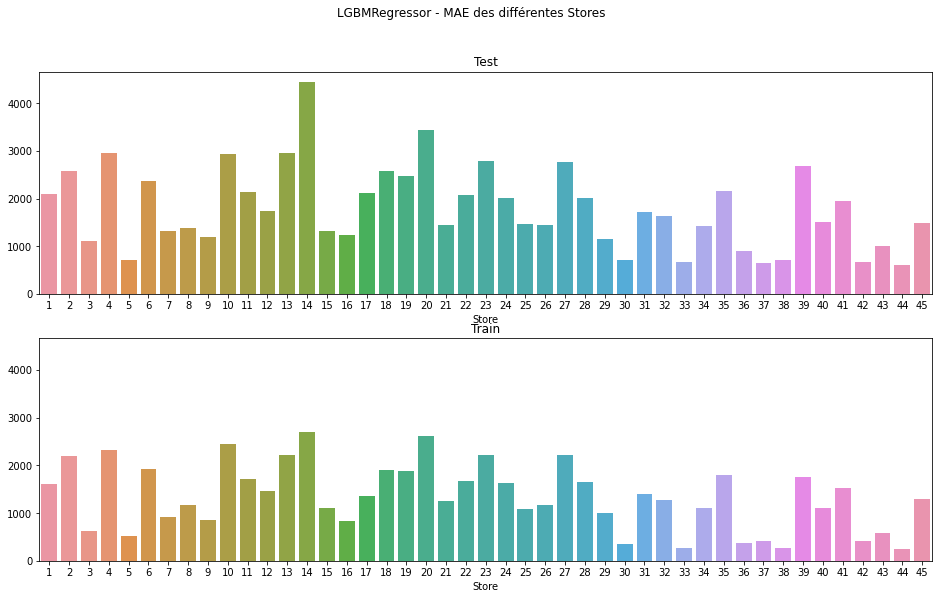

In [129]:
metrics_lgbm = metrics_(d_test_lgbm, d_train_lgbm)
plot_metrics(metrics_lgbm, model_lgbm)

 ---- Features Importance


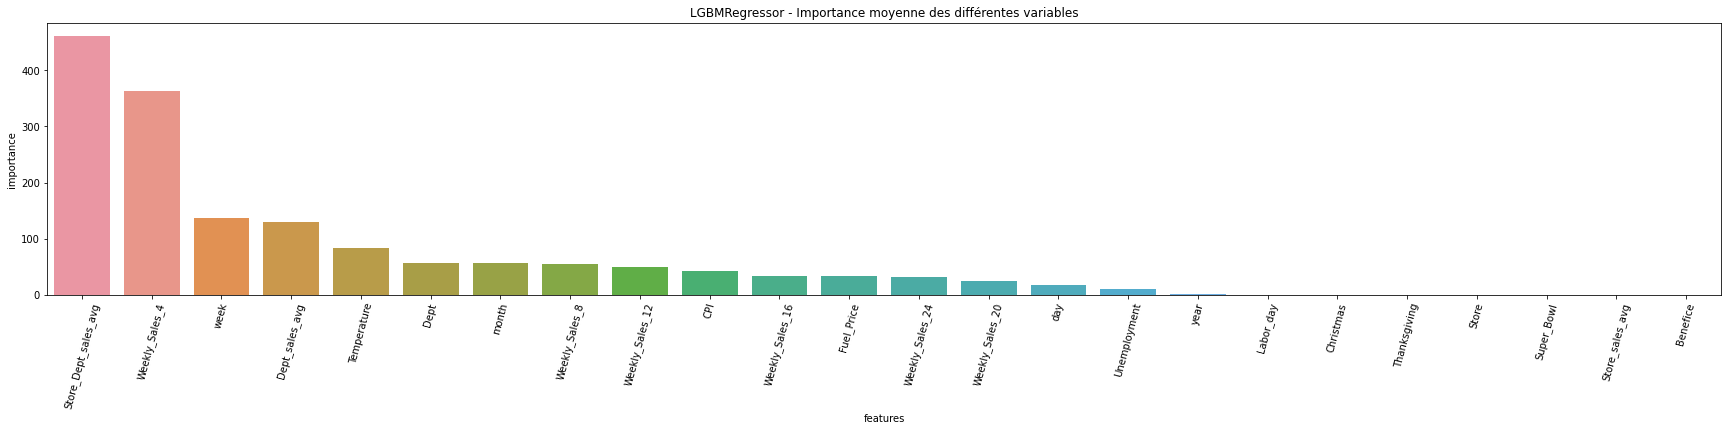

In [67]:
imp_plot(importance_df_lgbm, model_lgbm)

#### 1 - 2 - RandomForestRegressor


In [68]:
model_rf, d_test_rf, d_train_rf,importance_df_rf, t2_rf = model(
  model = RandomForestRegressor())


Succès !
L'opération a duré 336.88 sec


 -------> RMSE
 <--> Train : 2054.01
 <--> Test  : 4071.48


 -------> MAE
 <--> Train : 680.34
 <--> Test  : 1938.84


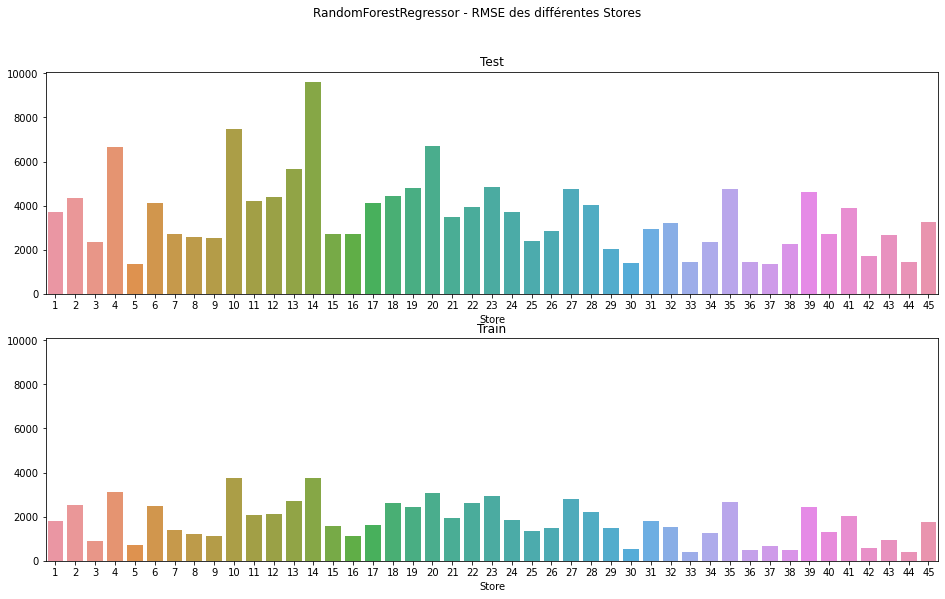

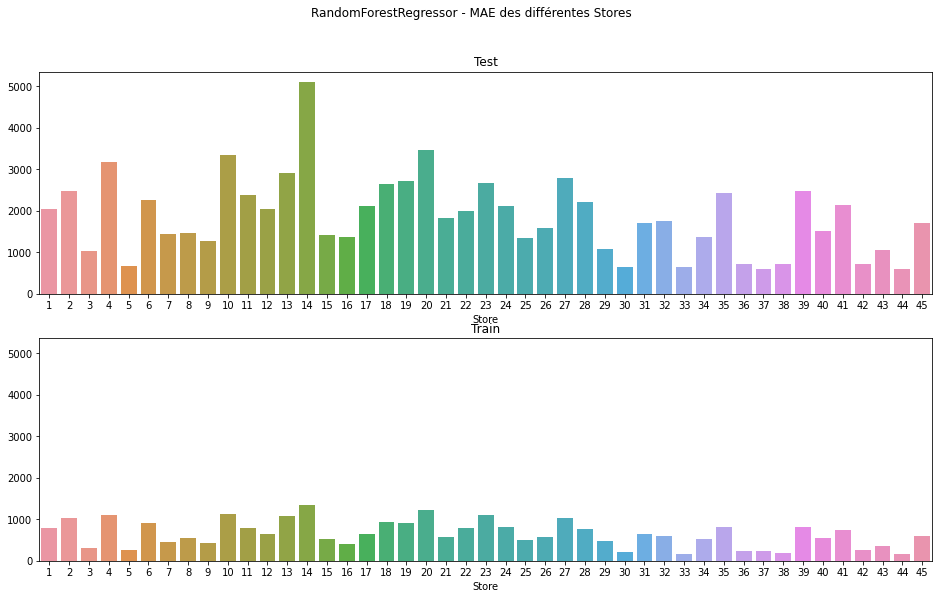

In [69]:
metrics_rf = metrics_(d_test_rf, d_train_rf)
plot_metrics(metrics_rf, model_rf)

 ---- Features Importance


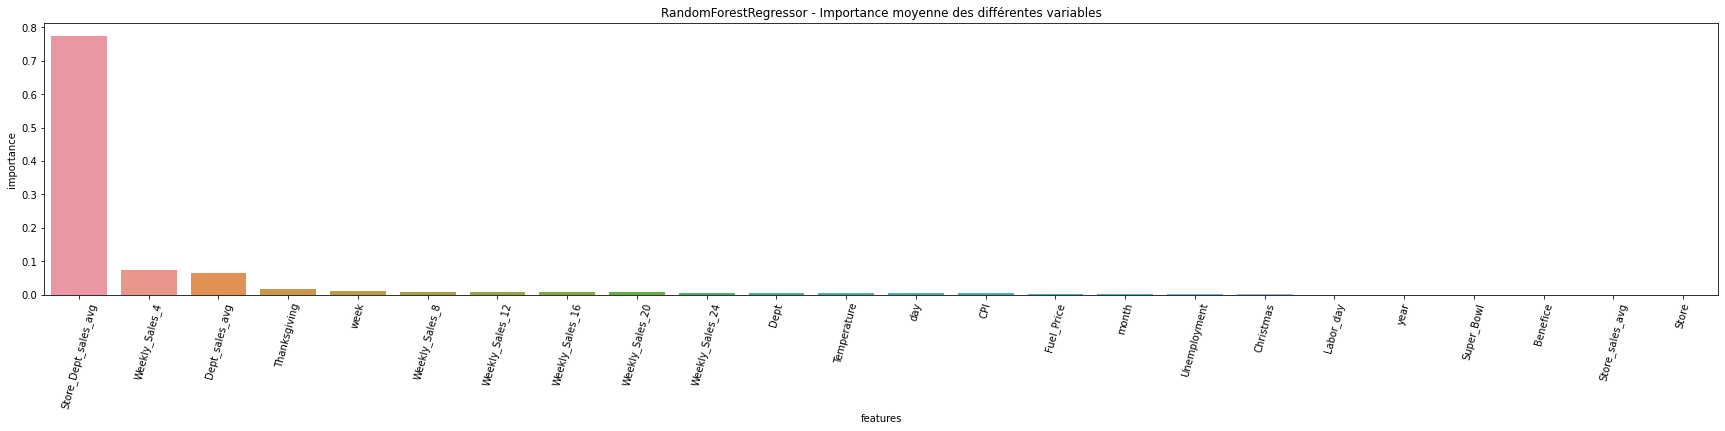

In [70]:
imp_plot(importance_df_rf, model_rf)

#### 1 - 3 - CatboostRegressor

In [71]:
pip install catboost

In [72]:
model_ctb, d_test_ctb, d_train_ctb,importance_df_ctb, t2_ctb = model(
  model = CatBoostRegressor())


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
6:	learn: 16658.1881232	total: 35.1ms	remaining: 4.98s
7:	learn: 15997.5887380	total: 41.4ms	remaining: 5.14s
8:	learn: 15382.2339181	total: 45.2ms	remaining: 4.98s
9:	learn: 14821.1247144	total: 49ms	remaining: 4.85s
10:	learn: 14296.6908913	total: 52.9ms	remaining: 4.76s
11:	learn: 13823.9157987	total: 56.5ms	remaining: 4.65s
12:	learn: 13345.3554531	total: 60.1ms	remaining: 4.57s
13:	learn: 12925.0577517	total: 63.9ms	remaining: 4.5s
14:	learn: 12515.4354447	total: 67.7ms	remaining: 4.45s
15:	learn: 12088.0356823	total: 71.7ms	remaining: 4.41s
16:	learn: 11699.2599044	total: 75.7ms	remaining: 4.38s
17:	learn: 11347.6025261	total: 79.4ms	remaining: 4.33s
18:	learn: 11037.3144087	total: 83.3ms	remaining: 4.3s
19:	learn: 10721.8253456	total: 87.1ms	remaining: 4.27s
20:	learn: 10408.9418535	total: 90.9ms	remaining: 4.24s
21:	learn: 10143.8424380	total: 94.5ms	remaining: 4.2s
22:	learn: 9900.9964181	total: 98.3

 -------> RMSE
 <--> Train : 1892.77
 <--> Test  : 3426.7


 -------> MAE
 <--> Train : 1099.99
 <--> Test  : 1732.89


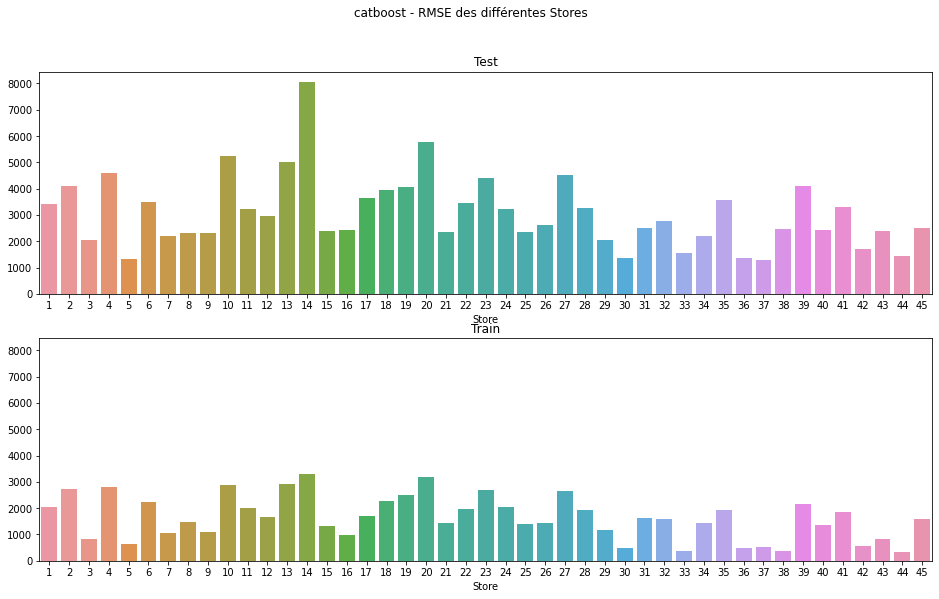

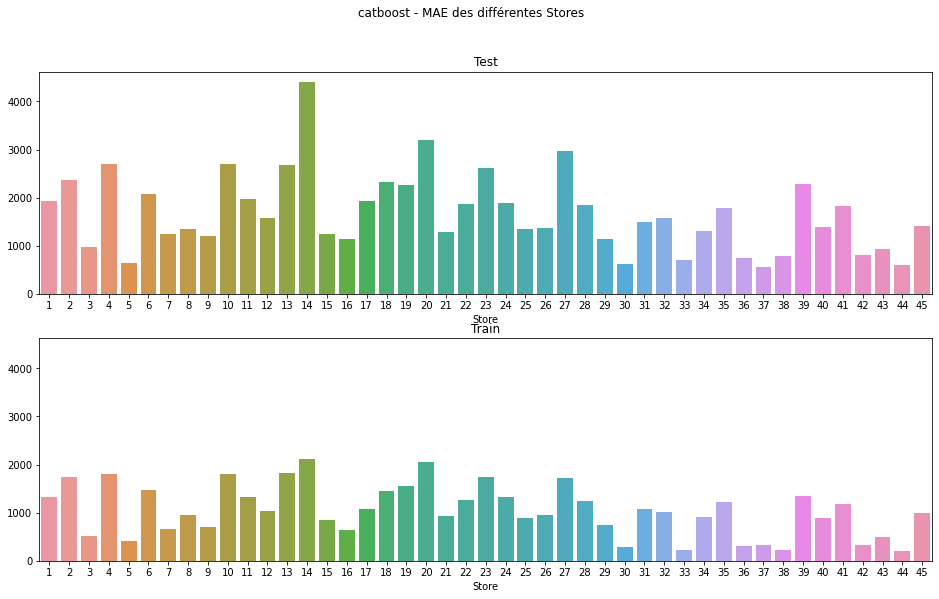

In [73]:
metrics_ctb = metrics_(d_test_ctb, d_train_ctb)
plot_metrics(metrics_ctb, model_ctb)

 ---- Features Importance


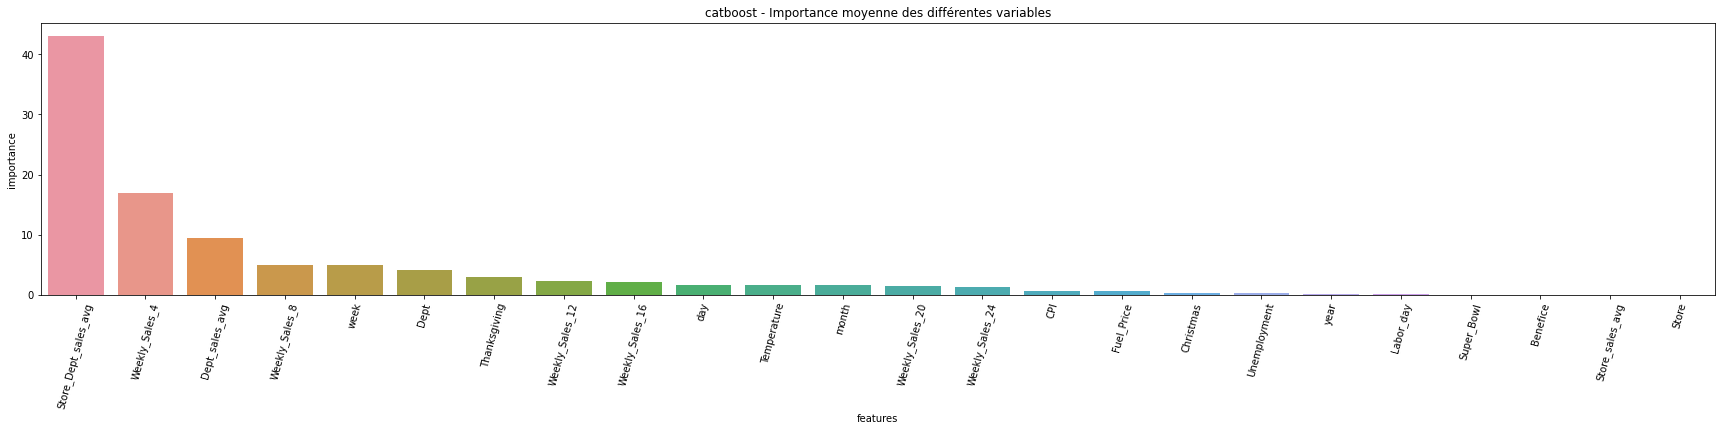

In [74]:
imp_plot(importance_df_ctb, model_ctb)

#### 1 - 4 - XgBoostRegressor

In [75]:
model_xgb, d_test_xgb, d_train_xgb,importance_df_xgb, t2_xgb = model(
  model = XGBRegressor(objective="reg:squarederror"))

Succès !
L'opération a duré 51.71 sec


 -------> RMSE
 <--> Train : 4585.03
 <--> Test  : 4214.06


 -------> MAE
 <--> Train : 2067.6
 <--> Test  : 2084.48


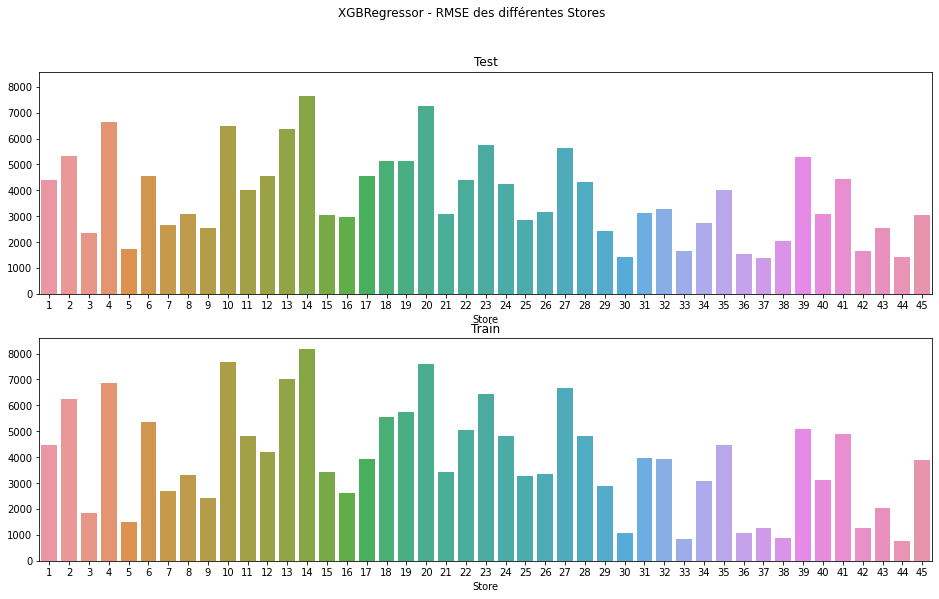

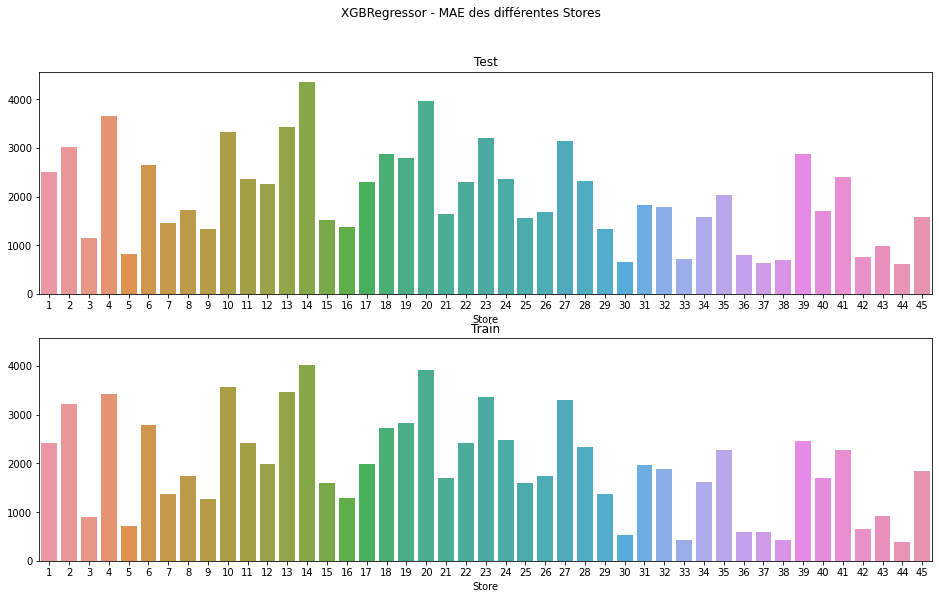

In [76]:
metrics_xgb = metrics_(d_test_xgb, d_train_xgb)
plot_metrics(metrics_xgb, model_xgb)

 ---- Features Importance


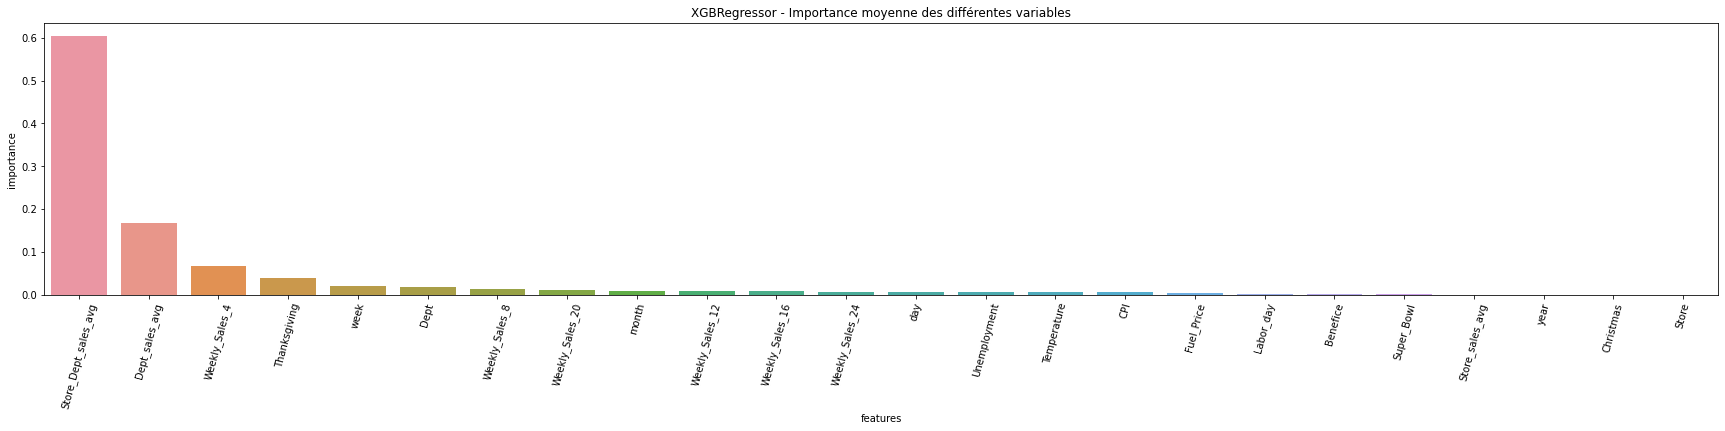

In [77]:
imp_plot(importance_df_xgb, model_xgb)

#### 1 - 5 - Perfs

In [131]:
perfs = pd.DataFrame(
    
    {"RMSE": [round(np.sqrt(mean_squared_error(d_test_lr["Weekly_Sales"], d_test_lr['y_pred_test'])),2),    round(np.sqrt(mean_squared_error(d_test_lgbm["Weekly_Sales"], d_test_lgbm['y_pred_test'])),2),
              round(np.sqrt(mean_squared_error(d_test_rf["Weekly_Sales"], d_test_rf['y_pred_test'])),2),    round(np.sqrt(mean_squared_error(d_test_ctb["Weekly_Sales"], d_test_ctb['y_pred_test'])),2),
              round(np.sqrt(mean_squared_error(d_test_xgb["Weekly_Sales"], d_test_xgb['y_pred_test'])),2)], 
    
     "MAE" : [round(mean_absolute_error(d_test_lr["Weekly_Sales"], d_test_lr['y_pred_test']),2),            round(mean_absolute_error(d_test_lgbm["Weekly_Sales"], d_test_lgbm['y_pred_test']),2),
              round(mean_absolute_error(d_test_rf["Weekly_Sales"], d_test_rf['y_pred_test']),2),            round(mean_absolute_error(d_test_ctb["Weekly_Sales"], d_test_ctb['y_pred_test']),2),
              round(mean_absolute_error(d_test_xgb["Weekly_Sales"], d_test_xgb['y_pred_test']),2)],

"RMSE_PCT" :[round(100 * np.sqrt(np.mean((d_test_lr["Weekly_Sales"] - d_test_lr["y_pred_test"]) ** 2))/np.mean(d_test_lr["y_pred_test"]), 2),
             round(100 * np.sqrt(np.mean((d_test_lgbm["Weekly_Sales"] - d_test_lgbm["y_pred_test"]) ** 2))/np.mean(d_test_lgbm["y_pred_test"]), 2),
             round(100 * np.sqrt(np.mean((d_test_rf["Weekly_Sales"] - d_test_rf["y_pred_test"]) ** 2))/np.mean(d_test_rf["y_pred_test"]), 2),
             round(100 * np.sqrt(np.mean((d_test_ctb["Weekly_Sales"] - d_test_ctb["y_pred_test"]) ** 2))/np.mean(d_test_ctb["y_pred_test"]), 2),
             round(100 * np.sqrt(np.mean((d_test_xgb["Weekly_Sales"] - d_test_xgb["y_pred_test"]) ** 2))/np.mean(d_test_xgb["y_pred_test"]), 2)],
     

     "TEMPS(sec)" : [t2_lr, t2_lgbm, t2_rf, t2_ctb, t2_xgb]},
    index=["LinearRegression", "LGBMRegressor", "RandomForestRegressor", "catboost","XGBRegressor"]
)

In [132]:
perfs

,RMSE,MAE,RMSE_PCT,TEMPS(sec)
LinearRegression,5251.66,3033.24,35.92,3.236315
LGBMRegressor,3778.99,1862.99,24.34,18.890098
RandomForestRegressor,4071.48,1938.84,24.93,336.882647
catboost,3426.70,1732.89,21.76,227.158201
XGBRegressor,4214.06,2084.48,27.18,51.709990


### 7 - 2 - Méthodes Classiques

# 8 - Selection de variables

In [50]:
from sklearn.linear_model import Ridge, Lasso, LassoLarsIC, ElasticNet

In [51]:
def reg_pen(estimateur):

  a = pd.DataFrame()
        # POUR ÉVITER DE DIVISER PAR 0 EN FAISANT LE np.log10
  EPSILON = 1e-4
  importance_df = pd.DataFrame()
  

  d_test = pd.DataFrame()
  d_train = pd.DataFrame()
  stores = df.Store.unique()
  for store in stores:

    df_ = df[df['Store']==store]

    train = df_.loc[:'2011-12-30']
    #train = df_.loc[:'2010-05-31']

    scaler = MinMaxScaler()
    X_train = train.drop("Weekly_Sales", axis = 1)
    X_train_ = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train_, columns = X_train.columns)

    y_train = train["Weekly_Sales"]

    # Validation Prediction
    test = df_.loc['2012-01-06':]
    #test = df_.loc['2010-06-01':]

    test_ = test.copy()

    X_test = test.drop("Weekly_Sales", axis = 1)
    X_test_ = scaler.transform(X_test)
    X_test = pd.DataFrame(X_test_, columns = X_test.columns)
    y_test = test["Weekly_Sales"]
    X_test = X_test.set_index(y_test.index)
    y_test = test["Weekly_Sales"]

      # Train and validate
    model = estimateur
    xxx, yyy = X_train, y_train
    model.fit(xxx, yyy)
    a["R2_Store_"+str(store)] = model.score(xxx, yyy)

    a["features"] = [ col for col in xxx.columns if col != "Weekly_Sales"]
    a["coefs_"+str(store)] = model.coef_
  
  a["coefs"]  = np.mean(a[[col for col in a.columns if col.startswith("coefs")]], axis = 1)
  a["R2"]     = np.mean(a[[col for col in a.columns if col.startswith("R2")]], axis = 1)

  a = a[["features", "coefs", "R2"]]
  a = a.sort_values(by = "coefs", ascending = True)
  print("Le", model, "a sélectionné " + str(a[a["coefs"]!=0].shape[0]) + " variables et en a éliminé " +  str(a[a["coefs"]==0].shape[0]))
  print("R2 : "+str(round(np.mean(a['R2']), 2)))
  vars = list(a[a["coefs"]!=0]["features"])
  print("Les variables sélectionnées sont : \n"+ str(vars))
  print("Les variables supprimées sont : \n"+ str(list(a[a["coefs"]==0]["features"])))
  return a


In [52]:
ridge = reg_pen(Ridge())

Le Ridge() a sélectionné 22 variables et en a éliminé 2
R2 : 0.89
Les variables sélectionnées sont : 
['Weekly_Sales_20', 'Weekly_Sales_16', 'Weekly_Sales_8', 'Weekly_Sales_12', 'Christmas', 'Weekly_Sales_24', 'Temperature', 'year', 'Labor_day', 'Dept', 'day', 'week', 'Unemployment', 'CPI', 'Benefice', 'Fuel_Price', 'Super_Bowl', 'Dept_sales_avg', 'month', 'Thanksgiving', 'Weekly_Sales_4', 'Store_Dept_sales_avg']
Les variables supprimées sont : 
['Store_sales_avg', 'Store']


In [53]:
lasso = reg_pen(Lasso())

Le Lasso() a sélectionné 22 variables et en a éliminé 2
R2 : 0.89
Les variables sélectionnées sont : 
['Weekly_Sales_8', 'Weekly_Sales_16', 'Weekly_Sales_20', 'Weekly_Sales_12', 'Christmas', 'Weekly_Sales_24', 'Temperature', 'year', 'Labor_day', 'Dept', 'day', 'week', 'Dept_sales_avg', 'Unemployment', 'CPI', 'Benefice', 'Fuel_Price', 'Super_Bowl', 'month', 'Thanksgiving', 'Weekly_Sales_4', 'Store_Dept_sales_avg']
Les variables supprimées sont : 
['Store_sales_avg', 'Store']


In [54]:
elnet = reg_pen(ElasticNet())

Le ElasticNet() a sélectionné 22 variables et en a éliminé 2
R2 : 0.32
Les variables sélectionnées sont : 
['Temperature', 'year', 'Christmas', 'Unemployment', 'Fuel_Price', 'day', 'Labor_day', 'Super_Bowl', 'Benefice', 'CPI', 'Thanksgiving', 'week', 'month', 'Dept', 'Weekly_Sales_24', 'Weekly_Sales_20', 'Weekly_Sales_16', 'Weekly_Sales_12', 'Weekly_Sales_8', 'Weekly_Sales_4', 'Dept_sales_avg', 'Store_Dept_sales_avg']
Les variables supprimées sont : 
['Store', 'Store_sales_avg']


In [55]:
lslars = reg_pen(LassoLarsIC())

Le LassoLarsIC() a sélectionné 22 variables et en a éliminé 2
R2 : 0.89
Les variables sélectionnées sont : 
['week', 'Weekly_Sales_8', 'Weekly_Sales_16', 'Weekly_Sales_20', 'Weekly_Sales_12', 'Christmas', 'Temperature', 'Weekly_Sales_24', 'year', 'Dept', 'Dept_sales_avg', 'Labor_day', 'Fuel_Price', 'Unemployment', 'Benefice', 'CPI', 'Super_Bowl', 'Thanksgiving', 'day', 'Weekly_Sales_4', 'Store_Dept_sales_avg', 'month']
Les variables supprimées sont : 
['Store_sales_avg', 'Store']


On remarque que les variables supprimées ne sont que de 2, on peut alors ne pas considérer les regressions pénalisées.


# 9 - Evaluation de la performance des modèles (recherche d'hyperparamètres, contrôle de l’overfitting, comparaison des performances) sur différents horizons de prédiction - Expanding Windows

On va faire des expanding windows de 6 mois chaque fois

In [ ]:
[
 df[(df["year"]==2010) & (df["month"]==2)].index[0], df[(df["year"]==2010) & (df["month"]==6)].index[-1], df[(df["year"]==2010) & (df["month"]==7)].index[0], df[(df["year"]==2010) & (df["month"]==12)].index[-1], 
 
 df[(df["year"]==2011) & (df["month"]==1)].index[0], df[(df["year"]==2011) & (df["month"]==6)].index[-1], df[(df["year"]==2011) & (df["month"]==7)].index[0], df[(df["year"]==2011) & (df["month"]==12)].index[-1], 
 
 df[(df["year"]==2012) & (df["month"]==1)].index[0], df[(df["year"]==2012) & (df["month"]==6)].index[-1], df[(df["year"]==2012) & (df["month"]==7)].index[0], df[(df["year"]==2012) & (df["month"]==10)].index[-1], 
 
 ]

In [24]:

train_1 = df.loc['2010-02-05':'2010-12-31'] # 1 an (année 2010)
test_1  = df.loc['2011-01-07':'2011-06-24'] # 6 mois (Janv à Juin 2011)

train_2 = df.loc['2010-02-05':'2011-06-24'] # 1 an et 6 mois (Debut 2010 à Juin 2011)
test_2  = df.loc['2011-07-01':'2011-12-30'] # 6 mois (Juillet à Décembre 2011)

train_3 = df.loc['2010-02-05':'2011-12-30'] # 2 ans (Début 2010 à Fin 2011)
test_3  = df.loc['2012-01-06':'2012-06-29'] # 6 mois (Janv à Juin 2012)

train_4 = df.loc['2010-02-05':'2012-06-29'] # 2 ans et 6 mois (Début 2010 à Juin 2012)
test_4  = df.loc['2012-07-06':'2012-10-26'] # 6 mois (Juillet 2012 à Déc 2012)

#### 9 - 0 - Fn

In [25]:
def metrics_np(predictions_test, predictions_train):

  metrics_dict = {"Store" : [], "RMSE_train" : [], "RMSE_test" : [], "MAE_train" : [], 
                                "MAE_test" : [],"RMSE_PCT_train": [], "RMSE_PCT_test": []}

  for store in predictions_train["Store"].unique():

    m_test = predictions_test[predictions_test["Store"]==store]
    rmse = np.sqrt(mean_squared_error(m_test["Weekly_Sales"], m_test["y_pred_test"]))
    mae = mean_absolute_error(m_test["Weekly_Sales"], m_test["y_pred_test"])
    rmse_pct = 100 * np.sqrt(np.mean((m_test["Weekly_Sales"] - m_test["y_pred_test"]) ** 2))/np.mean(m_test["y_pred_test"])

    m_train = predictions_train[predictions_train["Store"]==store]
    rmse_train = np.sqrt(mean_squared_error(m_train["Weekly_Sales"], m_train["y_pred_train"]))
    mae_train = mean_absolute_error(m_train["Weekly_Sales"], m_train["y_pred_train"])
    rmse_pct_train = 100 * np.sqrt(np.mean((m_train["Weekly_Sales"] - m_train["y_pred_train"]) ** 2))/np.mean(m_train["y_pred_train"])

    metrics_dict["Store"].append(store)

    metrics_dict["RMSE_train"].append(rmse_train)
    metrics_dict["RMSE_test"].append(rmse)

    metrics_dict["MAE_train"].append(mae_train) 
    metrics_dict["MAE_test"].append(mae)

    metrics_dict["RMSE_PCT_train"].append(rmse_pct_train)
    metrics_dict["RMSE_PCT_test"].append(rmse_pct)

  metrics = pd.DataFrame(metrics_dict)
  """  
  print(" -------> RMSE")
  print(" <--> Train : "+str(round(np.sqrt(mean_squared_error(predictions_train["Weekly_Sales"], predictions_train['y_pred_train'])),2)))
  print(" <--> Test  : "+str(round(np.sqrt(mean_squared_error(predictions_test["Weekly_Sales"], predictions_test['y_pred_test'])),2)))
  print("\n")
  print(" -------> MAE")
  print(" <--> Train : "+str(round(mean_absolute_error(predictions_train["Weekly_Sales"], predictions_train['y_pred_train']),2)))
  print(" <--> Test  : "+str(round(mean_absolute_error(predictions_test["Weekly_Sales"], predictions_test['y_pred_test']),2)))
  """
  return metrics


In [28]:
def exp_win(model, exp_window):

  #print("--> Expanding window : ", exp_window, "<--")

  importance_df = pd.DataFrame()
  stores = df.Store.unique()
  d_test = pd.DataFrame()
  d_train = pd.DataFrame()
  metrics = {}


  t1 = time.time()
  for store in stores:

    df_ = df[df['Store']==store]

    if exp_window == 1:
      train = df_.loc['2010-02-05':'2010-12-31'] # 1 an
      test  = df_.loc['2011-01-07':'2011-06-24'] # 6 mois
    elif exp_window == 2:
      train = df_.loc['2010-02-05':'2011-06-24'] # 1 an et 6 mois
      test  = df_.loc['2011-07-01':'2011-12-30'] # 6 mois
    elif exp_window == 3:
      train = df_.loc['2010-02-05':'2011-12-30'] # 2 ans
      test  = df_.loc['2012-01-06':'2012-06-29'] # 6 mois
    elif exp_window == 4:
      train = df_.loc['2010-02-05':'2012-06-29'] # 2 ans et 6 mois
      test  = df_.loc['2012-07-06':'2012-10-26'] # 6 mois

    #train = df_.loc[:'2011-12-30']
    #train = df_.loc[:'2010-05-31']

    scaler = MinMaxScaler()
    X_train = train.drop("Weekly_Sales", axis = 1)
    X_train_ = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train_, columns = X_train.columns)

    y_train = train["Weekly_Sales"]

    # Validation Prediction
    #test = df_.loc['2012-01-06':]
    #test = df_.loc['2010-06-01':]

    X_test = test.drop("Weekly_Sales", axis = 1)
    X_test_ = scaler.transform(X_test)
    X_test = pd.DataFrame(X_test_, columns = X_test.columns)
    y_test = test["Weekly_Sales"]

    X_test = X_test.set_index(y_test.index)
    y_test = test["Weekly_Sales"]

      # Train and validate
    model = model

    # Fit model
    model.fit(X_train, y_train)

    test_pred = model.predict(X_test)
    pred = pd.DataFrame(test_pred)
    pred = pred.set_index(y_test.index)
    predictions_test = pd.concat([y_test, pred], axis = 1)
    predictions_test.columns = ["Weekly_Sales", "y_pred_test"]
    predictions_test["Store"] = store
    #predictions_test["erreur_test"] = predictions_test["Weekly_Sales"] - predictions_test["y_pred_test"]

    test_pred_train = model.predict(X_train)
    pred_train = pd.DataFrame(test_pred_train)
    pred_train = pred_train.set_index(y_train.index)
    predictions_train = pd.concat([y_train, pred_train], axis = 1)
    predictions_train.columns = ["Weekly_Sales", "y_pred_train"]
    predictions_train["Store"] = store
    #predictions_train["erreur_train"] = predictions_train["Weekly_Sales"] - predictions_train["y_pred_train"]

    d_test = pd.concat([d_test, predictions_test], axis = 0)
    d_train = pd.concat([d_train, predictions_train], axis = 0)

    #importance_df["features"] = [ col for col in X_train.columns if col != "Weekly_Sales"]
    #importance_df["importance_"+str(store)] = model.feature_importances_
  
  #importance_df["importance"] = np.mean(importance_df[[col for col in importance_df.columns if col!= "features"]], axis = 1)
  #importance_df = importance_df[["features", "importance"]]

  t2 = time.time() - t1

  #assert d_test.shape[0]  == df[df['year']== 2012].shape[0]
  #assert d_train.shape[0] == df[df['year']== 2010].shape[0] + df[df['year']==2011].shape[0]

  #print('Model is calculating the metrics !')
  metrics = metrics_np(d_test, d_train)
  t2 = time.time() - t1
  #print("Succès !")
  #print("L'opération a duré "+str(round(t2, 2))+" sec")
  #print("\n")
  
  return t2, model, exp_window, d_test, d_train



In [32]:
def expand_all_windows(model):
  
  a ={
      
      "RMSE"             : [], 
      "RMSE_TRAIN"       : [],

      "MAE"              : [],
      "MAE_TRAIN"        : [],

      "RMSE_PCT"         : [],
      "RMSE_PCT_TRAIN"   : [],
      
      "WIND"             : [],
      "MODEL"            : [],
      "TEMPS(sec)"       : []
      
      }

  t3 = time.time()
  for i in range(1,5):
    t2, model, exp_window, d_test, d_train = exp_win(model, i)
    # TEST
    a["RMSE"].append(round(np.sqrt(mean_squared_error(d_test["Weekly_Sales"], d_test['y_pred_test'])),2))
    a["MAE"].append(round(mean_absolute_error(d_test["Weekly_Sales"], d_test['y_pred_test']),2))
    a["RMSE_PCT"].append(round(100*np.sqrt(np.mean((d_test["Weekly_Sales"] - d_test["y_pred_test"]) ** 2))/np.mean(d_test["y_pred_test"]),2))

    # TRAIN
    a["RMSE_TRAIN"].append(round(np.sqrt(mean_squared_error(d_train["Weekly_Sales"], d_train['y_pred_train'])),2))
    a["MAE_TRAIN"].append(round(mean_absolute_error(d_train["Weekly_Sales"], d_train['y_pred_train']),2))
    a["RMSE_PCT_TRAIN"].append(round(100*np.sqrt(np.mean((d_train["Weekly_Sales"] - d_train["y_pred_train"]) ** 2))/np.mean(d_train["y_pred_train"]),2))

    a["WIND"].append(exp_window)
    a["MODEL"].append(str(re.findall(r"\w+", str(model))[0]))
    a["TEMPS(sec)"].append(round(t2,2))

  data = pd.DataFrame(a)
  t4 = time.time() - t3

  print("Succès !")

  if t4 > 200:
    print("L'opération a duré environ "+str(int(t2/60))+" min")

  else:

    print("L'opération a duré "+str(round(t4, 2))+" sec")

  return data


#### 9 - 1 - XGBRegressor

In [ ]:
xgb = expand_all_windows(XGBRegressor())

In [36]:
xgb.head()

,RMSE,MAE,RMSE_PCT,RMSE_TRAIN,MAE_TRAIN,RMSE_PCT_TRAIN,WIND,MODEL,TEMPS(sec)
0,11668.40,3734.71,69.65,4435.75,2006.31,27.27,1,XGBRegressor,15.59
1,6727.08,2742.29,40.18,4363.53,1959.41,27.37,2,XGBRegressor,21.99
2,4316.40,2119.66,28.03,4585.03,2067.60,28.47,3,XGBRegressor,29.72
3,3803.66,1895.20,23.98,4498.76,2022.75,28.09,4,XGBRegressor,37.08


#### 9 - 2 - LGBMRegressor

In [118]:
lgbm = expand_all_windows(LGBMRegressor(boosting_type='gbdt', num_leaves=31, max_depth=- 1, learning_rate=0.1
       ))

Succès !
L'opération a duré 59.61 sec


In [119]:
lgbm.head()

,RMSE,MAE,RMSE_PCT,RMSE_TRAIN,MAE_TRAIN,RMSE_PCT_TRAIN,WIND,MODEL,TEMPS(sec)
0,9110.08,3993.27,54.54,3996.26,1383.53,24.56,1,LGBMRegressor,16.00
1,6804.27,2483.83,40.81,3594.87,1342.44,22.54,2,LGBMRegressor,12.84
2,3797.92,1872.66,24.55,3459.74,1413.97,21.48,3,LGBMRegressor,14.56
3,3281.19,1647.47,20.77,3295.91,1391.29,20.57,4,LGBMRegressor,16.15


#### 9 - 3 - CatBoostRegressor

In [43]:
ctb = expand_all_windows(CatBoostRegressor(iterations=None,
                        learning_rate=None,
                        depth=None,
                        l2_leaf_reg=None,
                        model_size_reg=None,
                        rsm=None,
                        loss_function='RMSE',
                        border_count=None,
                        feature_border_type=None))

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
6:	learn: 16373.0365857	total: 30.8ms	remaining: 4.37s
7:	learn: 15655.3043043	total: 34.8ms	remaining: 4.32s
8:	learn: 15019.1123592	total: 39.1ms	remaining: 4.31s
9:	learn: 14419.9932106	total: 43.6ms	remaining: 4.32s
10:	learn: 13846.5107852	total: 47.7ms	remaining: 4.29s
11:	learn: 13321.6137059	total: 52ms	remaining: 4.28s
12:	learn: 12834.0413255	total: 59.7ms	remaining: 4.53s
13:	learn: 12382.4490844	total: 70ms	remaining: 4.93s
14:	learn: 11946.7069753	total: 74.3ms	remaining: 4.88s
15:	learn: 11537.3879089	total: 78.7ms	remaining: 4.84s
16:	learn: 11160.1019479	total: 83.1ms	remaining: 4.81s
17:	learn: 10802.5876759	total: 87.6ms	remaining: 4.78s
18:	learn: 10475.2440114	total: 92.1ms	remaining: 4.75s
19:	learn: 10158.9820043	total: 96.3ms	remaining: 4.72s
20:	learn: 9851.1259497	total: 101ms	remaining: 4.7s
21:	learn: 9584.9055725	total: 105ms	remaining: 4.66s
22:	learn: 9343.2995715	total: 109ms	re

In [44]:
ctb.head()

,RMSE,MAE,RMSE_PCT,RMSE_TRAIN,MAE_TRAIN,RMSE_PCT_TRAIN,WIND,MODEL,TEMPS(sec)
0,7730.61,3365.45,44.59,1805.25,1054.47,11.10,1,catboost,201.45
1,5471.69,2242.74,33.21,1824.62,1060.41,11.44,2,catboost,176.69
2,3476.74,1758.12,22.16,1892.77,1099.99,11.75,3,catboost,195.25
3,2962.71,1526.08,18.80,1900.74,1101.54,11.86,4,catboost,223.24


#### 9 - 4 - RandomForestRegressor

In [41]:
rf =  expand_all_windows(RandomForestRegressor(n_estimators=100, criterion='squared_error', max_depth=None, 
                                               min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                               max_features='auto'))

Succès !
L'opération a duré environ 7 min


In [42]:
rf.head()

,RMSE,MAE,RMSE_PCT,RMSE_TRAIN,MAE_TRAIN,RMSE_PCT_TRAIN,WIND,MODEL,TEMPS(sec)
0,9266.78,3629.84,51.57,2635.12,769.63,16.18,1,RandomForestRegressor,123.89
1,5767.71,2274.11,34.88,2263.17,690.28,14.18,2,RandomForestRegressor,218.94
2,4107.58,1963.38,25.18,2006.36,678.37,12.44,3,RandomForestRegressor,310.04
3,3263.98,1564.81,20.45,1853.93,634.39,11.56,4,RandomForestRegressor,450.89


In [39]:
lr =  expand_all_windows(LinearRegression()) 

Succès !
L'opération a duré 11.01 sec


In [40]:
lr.head()

,RMSE,MAE,RMSE_PCT,RMSE_TRAIN,MAE_TRAIN,RMSE_PCT_TRAIN,WIND,MODEL,TEMPS(sec)
0,14932.04,11253.06,89.93,7497.61,2959.57,46.08,1,LinearRegression,2.69
1,9790.55,4684.59,66.54,6743.47,2732.65,42.29,2,LinearRegression,2.62
2,5439.45,3033.76,37.60,7187.80,2839.18,44.63,3,LinearRegression,2.81
3,4526.12,2610.10,27.13,6781.21,2740.10,42.33,4,LinearRegression,2.82


# 10 - Discussion autour de la performance des modèles

#### 10 - 1 - Performance des modèles

In [120]:
performances = pd.concat([rf, xgb, lgbm, ctb, lr], axis = 0)

In [122]:
perf_per_rmse = performances.sort_values(by = "RMSE", ascending = True)

perf_per_rmse.head(20)

,RMSE,MAE,RMSE_PCT,RMSE_TRAIN,MAE_TRAIN,RMSE_PCT_TRAIN,WIND,MODEL,TEMPS(sec)
3,2962.71,1526.08,18.80,1900.74,1101.54,11.86,4,catboost,223.24
3,3263.98,1564.81,20.45,1853.93,634.39,11.56,4,RandomForestRegressor,450.89
3,3281.19,1647.47,20.77,3295.91,1391.29,20.57,4,LGBMRegressor,16.15
2,3476.74,1758.12,22.16,1892.77,1099.99,11.75,3,catboost,195.25
2,3797.92,1872.66,24.55,3459.74,1413.97,21.48,3,LGBMRegressor,14.56
3,3803.66,1895.20,23.98,4498.76,2022.75,28.09,4,XGBRegressor,37.08
2,4107.58,1963.38,25.18,2006.36,678.37,12.44,3,RandomForestRegressor,310.04
2,4316.40,2119.66,28.03,4585.03,2067.60,28.47,3,XGBRegressor,29.72
3,4526.12,2610.10,27.13,6781.21,2740.10,42.33,4,LinearRegression,2.82
2,5439.45,3033.76,37.60,7187.80,2839.18,44.63,3,LinearRegression,2.81


In [123]:
pprmse = perf_per_rmse.iloc[:3, :]

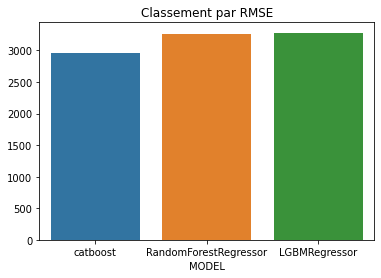

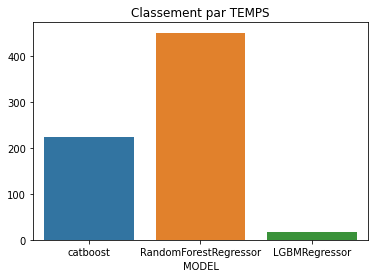

In [124]:
sns.barplot(x=pprmse["MODEL"], y=pprmse["RMSE"].values)
plt.title("Classement par RMSE")
plt.show()
print("\n")
sns.barplot(x=pprmse["MODEL"], y=pprmse["TEMPS(sec)"].values)
plt.title("Classement par TEMPS")
plt.show()

In [125]:
perf_per_mae = performances.sort_values(by = ["MAE"], ascending = True)

perf_per_mae.head(20)

,RMSE,MAE,RMSE_PCT,RMSE_TRAIN,MAE_TRAIN,RMSE_PCT_TRAIN,WIND,MODEL,TEMPS(sec)
3,2962.71,1526.08,18.80,1900.74,1101.54,11.86,4,catboost,223.24
3,3263.98,1564.81,20.45,1853.93,634.39,11.56,4,RandomForestRegressor,450.89
3,3281.19,1647.47,20.77,3295.91,1391.29,20.57,4,LGBMRegressor,16.15
2,3476.74,1758.12,22.16,1892.77,1099.99,11.75,3,catboost,195.25
2,3797.92,1872.66,24.55,3459.74,1413.97,21.48,3,LGBMRegressor,14.56
3,3803.66,1895.20,23.98,4498.76,2022.75,28.09,4,XGBRegressor,37.08
2,4107.58,1963.38,25.18,2006.36,678.37,12.44,3,RandomForestRegressor,310.04
2,4316.40,2119.66,28.03,4585.03,2067.60,28.47,3,XGBRegressor,29.72
1,5471.69,2242.74,33.21,1824.62,1060.41,11.44,2,catboost,176.69
1,5767.71,2274.11,34.88,2263.17,690.28,14.18,2,RandomForestRegressor,218.94


Les perfs dans le test, en prenant en compte MAE et RMSE ne changent pas l'ordre de qualité des modèles. Le meilleur modèle niveau performance est le catboost suivi du RandomForest et du Lgbm. Toutefois par soucis de ressources computationnelles, on va préférer le lgbm qui consomme moins de temps à fournir les estimations.

La 2e remarque est que globalement, les pires performances des modèles sont lorsque ces derniers ont moins de données historiques (WIND = 1), et que généralement plus la taille du train set augmente plus les performances s'améliorent.

Et si on comparait avec notre Benchmark ?

In [133]:
ppbench = perfs.iloc[1:, :].sort_values(by = ["RMSE"], ascending = True)

ppbench = ppbench.reset_index()

ppbench.columns = ['MODEL', 'RMSE', 'MAE', 'RMSE_PCT', 'TEMPS(sec)']

ppbench

,MODEL,RMSE,MAE,RMSE_PCT,TEMPS(sec)
0,catboost,3426.70,1732.89,21.76,227.158201
1,LGBMRegressor,3778.99,1862.99,24.34,18.890098
2,RandomForestRegressor,4071.48,1938.84,24.93,336.882647
3,XGBRegressor,4214.06,2084.48,27.18,51.709990


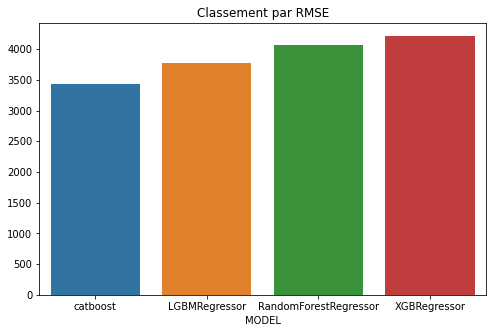

In [134]:
plt.figure(figsize = (8, 5))
sns.barplot(x = ppbench["MODEL"], y = ppbench["RMSE"].values)
plt.title("Classement par RMSE")
plt.show()

On fait nettement mieux que le Benchmark, les RMSE y sont plus élevées.




In [77]:
#Maintenant on va prendre notre meilleur modèle (Lgbm) et essayer de trouver les meilleurs hyperparamètres sur la période WIND = 4

# 11 - Synthèse et conclusions, pistes d’améliorations envisagées